In [1]:

import _init_
from constants import *
from set_path import *
from config import *
from functions import *

In [2]:
file = '/g/data/jh2/av5889/freshquokka/quokka/extern/grackle_data_files/input/CloudyData_UVB=HM2012.h5'
# file = '/g/data/jh2/av5889/quokka_myrepo/quokka/extern/grackle_data_files/input/CloudyData_UVB=FG2011.h5'
grackle = h5py.File(file)
array = grackle['CoolingRates/Primordial/MMW'][()]
#density(1.e-6, 1.e4), redshift(0,15), temperature(10., 1.e9)
table = array[:,0,:]
table_nH   = np.logspace(-10, 4, array.shape[0])
table_temp = np.logspace(1,  9, array.shape[2])

In [3]:

i=0
bins = 100
egas_arr = np.logspace(-21., -5., bins)
nH_arr   = np.logspace(-6.0, 4.0, int(bins))
T = np.zeros((egas_arr.shape[0],nH_arr.shape[0]))

for egas in egas_arr:
    j=0
    for nH in nH_arr:
        C = (gamma - 1.) * egas / (boltzmann_constant_cgs*nH)
        minT = C*np.amin(table)
        maxT = C*np.amax(table)
        def func(T):
            mu = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)
            return C*mu(T,nH)[0] - T

        T[i,j] = scipy.optimize.toms748(func, minT, maxT)
        j+=1
    i+=1

    
# temperature_table = interpolate.RectBivariateSpline(egas_arr, nH_arr, T)


In [6]:
f = 'plt500000/'

In [7]:
foextrap = os.path.join(scratch, 'sims/DiodeBC/GPUCheck_BC/FOExtrap/16pc/')
infile   = os.path.join(foextrap, 'metal_uniform.in')
dom_min, dom_max, ncells = getdomain(infile)
fac = 1
zrange = np.linspace(dom_min[2], dom_max[2], (fac*int(ncells[2])))
xrange = np.linspace(dom_min[0], dom_max[0], (fac*int(ncells[0])))
yrange = np.linspace(dom_min[1], dom_max[1], (fac*int(ncells[1])))

In [8]:
inputfile = os.path.join(foextrap, f)
print(inputfile)
ds   = yt.load(inputfile)
print("Time=", ds.current_time.to('Myr'))
lev = 0
data = ds.covering_grid(level=lev, left_edge=dom_min, dims=ds.domain_dimensions * fac, num_ghost_zones=0)
timestep = ds.current_time.to('Myr')

rho_gasFO = np.array(data['gasDensity'])
egasFO    = np.array(data['gasEnergy'])
eintFO    = np.array(data['gasInternalEnergy'])
vzFO = np.array(data['z-GasMomentum'])/rho_gasFO
vxFO = np.array(data['x-GasMomentum'])/rho_gasFO
vyFO = np.array(data['y-GasMomentum'])/rho_gasFO

yt : [INFO     ] 2024-03-06 09:30:10,041 Parameters: current_time              = 1.1616158793766832e+16
yt : [INFO     ] 2024-03-06 09:30:10,043 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-03-06 09:30:10,044 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-03-06 09:30:10,045 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


/scratch/jh2/av5889/sims/DiodeBC/GPUCheck_BC/FOExtrap/16pc/plt500000/
Time= 368.09385991858795 Myr


In [9]:
ext_dir = os.path.join(scratch, 'sims/DiodeBC/GPUCheck_BC/ExtDir/16pc/')
inputfile = os.path.join(ext_dir, f)
print(inputfile)
ds   = yt.load(inputfile)
print("Time=",ds.current_time.to('Myr'))
lev = 0
data = ds.covering_grid(level=lev, left_edge=dom_min, dims=ds.domain_dimensions * fac, num_ghost_zones=0)
timestep = ds.current_time.to('Myr')

rho_gasEX = np.array(data['gasDensity'])
egasEX    = np.array(data['gasEnergy'])
eintEX    = np.array(data['gasInternalEnergy'])
vzEX = np.array(data['z-GasMomentum'])/rho_gasEX
vxEX = np.array(data['x-GasMomentum'])/rho_gasEX
vyEX = np.array(data['y-GasMomentum'])/rho_gasEX

yt : [INFO     ] 2024-03-06 09:30:14,877 Parameters: current_time              = 1.1616158793766832e+16
yt : [INFO     ] 2024-03-06 09:30:14,878 Parameters: domain_dimensions         = [ 64  64 512]
yt : [INFO     ] 2024-03-06 09:30:14,879 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-03-06 09:30:14,881 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


/scratch/jh2/av5889/sims/DiodeBC/GPUCheck_BC/ExtDir/16pc/plt500000/
Time= 368.09385991858795 Myr


In [10]:
diff = np.abs(rho_gasEX-rho_gasFO)
np.amax(diff/rho_gasFO), np.amin(diff)

(0.0, 0.0)

In [11]:
np.amax(np.abs((egasFO-egasEX)))

0.0

In [12]:
egas0=eintEX
density = rho_gasEX
cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
rho0 = density*cloudy_H_mass_fraction/hydrogen_mass_cgs


logrho_arr = np.log10(nH_arr[:-1])
logrho     = np.log10(rho0)
delta_rho  = logrho_arr[1] - logrho_arr[0]
idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

logEgas_arr = np.log10(egas_arr[:-1])
logEgas     = np.log10(egas0)
delta_egas  = logEgas_arr[1] - logEgas_arr[0]
idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

tempEX = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
           wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
      (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
           wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  

In [13]:
egas0=eintFO
density = rho_gasFO
cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
rho0 = density*cloudy_H_mass_fraction/hydrogen_mass_cgs


logrho_arr = np.log10(nH_arr[:-1])
logrho     = np.log10(rho0)
delta_rho  = logrho_arr[1] - logrho_arr[0]
idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

logEgas_arr = np.log10(egas_arr[:-1])
logEgas     = np.log10(egas0)
delta_egas  = logEgas_arr[1] - logEgas_arr[0]
idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

tempFO = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
           wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
      (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
           wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  

/jobfs/110141821.gadi-pbs/ipykernel_3704616/2185184294.py:67: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[0].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(vzFO[:,plane,:])/kmps,\
/jobfs/110141821.gadi-pbs/ipykernel_3704616/2185184294.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(vzEX[:,plane,:])/kmps,\


Text(0.5, 0.5, '368.09')

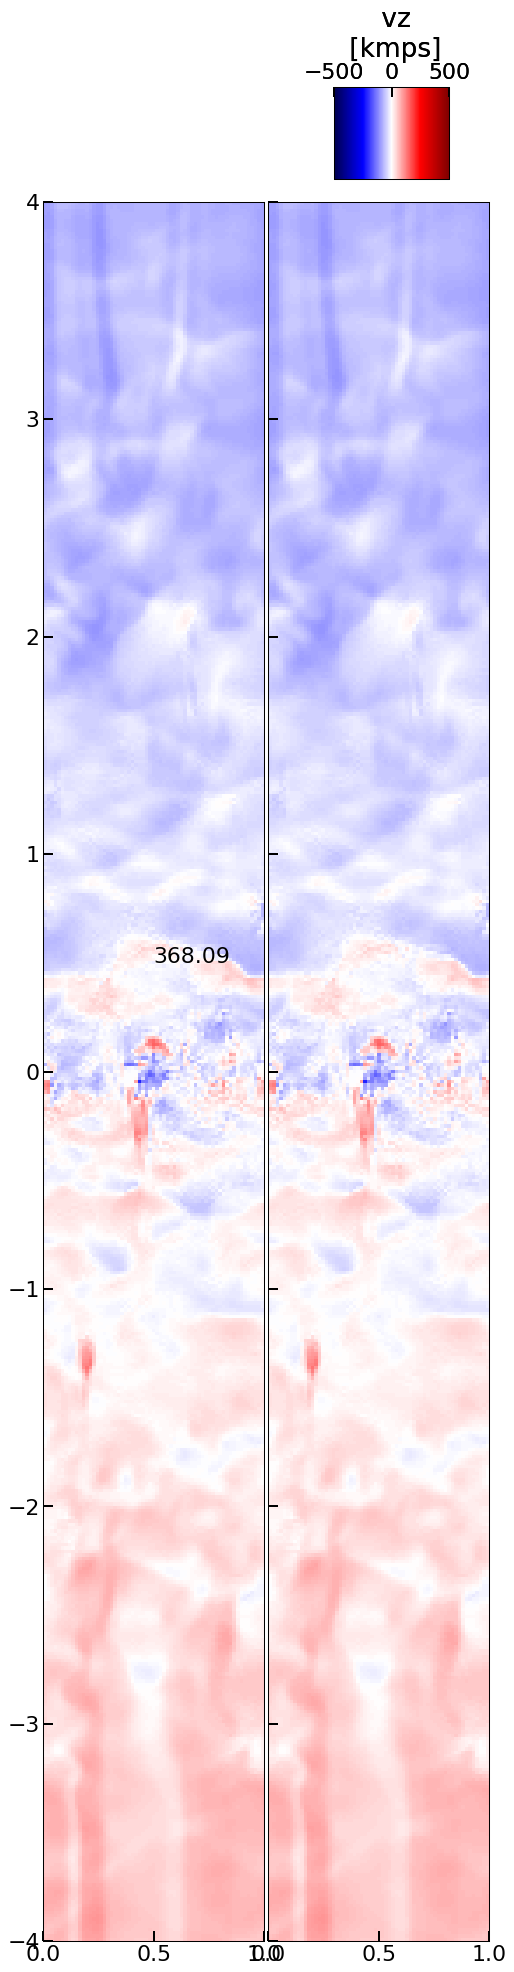

In [14]:
fig, ax = plt.subplots(1, 2, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(8, 32))
i=0

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.2
dx1 = 0.25
cbtitlex = 0.1
cbtitley = 16.5
plane = (int)(ncells[1]/2)
plane = 4

# plot = ax[0].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(diff[:,plane,:]/rho_gasFO[:,plane,:]),\
#                     vmin=0.0, vmax=1.5,
#                     cmap='Blues')
# cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(0.0, 1., 1.5))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" $\rho$" + "\n" + "[g cm$^{-3}$]")



# plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(rho_gasEX[:,plane,:]/mp),\
#                     norm=mcolors.LogNorm(vmin=1.e-6, vmax=4.e2),
#                     cmap='Blues')
# cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-6,  1.e-2, 1., 1.e2))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" $\rho$" + "\n" + "[g cm$^{-3}$]")



# plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(tempFO[:,plane,:]),\
#                     norm=mcolors.LogNorm(vmin=2.e2, vmax=5.e7),
#                     cmap='afmhot')
# cax = fig.add_axes([cbarx + dx1, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e2, 1.e4,1.e5, 1.e6,1.e8))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" T" + "\n" + " [K]")
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)

# plot = ax[0].pcolormesh(yrange/kpc,xrange/kpc, np.transpose(eint[:,:,plane]),\
#                     norm=mcolors.LogNorm(vmin=9.e-16, vmax=5.e-13),
#                     cmap='afmhot')
# cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-16, 1.e-15, 1.e-14, 1.e-13))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" eint" )

# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)


# plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(eint[:,plane,:]),\
#                     norm=mcolors.LogNorm(vmin=9.e-21, vmax=5.e-10),
#                     cmap='afmhot')
# cax = fig.add_axes([cbarx + 3.*dx1, cbary, cblen, cbheight])
# fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-20, 1.e-16, 1.e-10, 1.e-8))
# cax.xaxis.set_ticks_position('top')
# cax.set_title(r" eint" + "\n" + " [cgs]")
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)

# # ax[1].text(0.5,0.8, "%2.1f"%(ds.current_time.to("Myr")) + ' Myr', transform=ax[1].transAxes, fontsize=12)
# ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)


plot = ax[0].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(vzFO[:,plane,:])/kmps,\
                    vmin=-500., vmax=500.,
                    cmap='seismic')
cax = fig.add_axes([cbarx + 2.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-500.,0.0, 500.))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" vz" + "\n" + " [kmps]")
ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
# ax[2].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
# ax[0].plot(xrange[44]/kpc, yrange[125]/kpc, '*', color='red', markersize=12)


plot = ax[1].pcolormesh(yrange/kpc,zrange/kpc, np.transpose(vzEX[:,plane,:])/kmps,\
                    vmin=-500., vmax=500.,
                    cmap='seismic')
cax = fig.add_axes([cbarx + 2.*dx1, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(-500.,0.0, 500.))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" vz" + "\n" + " [kmps]")
ax[1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
ax[-1].tick_params(axis='y', labelleft=False, labelright=False, right=False, left=True)
# ax[0].plot(xrange[44]/kpc, yrange[125]/kpc, '*', color='red', markersize=12)



ax[0].text(0.5, 0.5, '%.2f'%(ds.current_time.to('Myr')))
# plt.setp(ax, 'ylim',(0.8,1.))
# plt.setp(ax, 'xlim',(0.2,0.4))
# plt.setp(ax, "ylim", (-4.,-3.))
# ax[0].text(0.4, 0.9, '%.2f'%(timestep) + ' Myr', transform = ax[0].transAxes, color='black')
# ax[0].text( 0.4, 0.95, 'Res=%d'%(res) +' pc', transform = ax[0].transAxes, color='black')


In [15]:
8.219528002e+15/Myr

260.9373968888889